# 图像复原与重建

经过了前面几章的内容，已经对图像处理的几种手段有了了解。这一章的安排如下：

1. 图像退化/复原过程的模型
2. 噪声模型
3. 只存在噪声的复原——空间滤波
4. 用频率域滤波消除周期噪声
5. 线性、位置不变的退化
6. 估计退化函数
7. 逆滤波
8. 最小均方误差滤波（维纳滤波）
9. 约束最小二乘方滤波
10. 几何均值滤波
11. 由投影重建图像

## 图像退化/复原过程的模型

在建模的时候，我们把一幅图像的退化过程简化为一个退化函数$h(x, y)$的卷积加一个加性噪声$n(x, y)$的干扰。而且这里的退化函数具有同一性，也就是对整幅图像都有相同的退化作用。

$$
g(x, y) = h(x, y)*f(x, y) + n(x, y) \Leftrightarrow G(x, y) = H(x, y)F(x, y) + N(x, y)
$$

这是一种比较理想的退化模型，虽然不能代表所有自然产生的图像退化，但还是能对图像复原方法的开发提供思路。

## 噪声模型

**白噪声**：当一个噪声的傅里叶谱是常量的时候，这个噪声被称为白噪声。因为这种噪声中不同频率的成分占比相同，就像自然界中的白光一样。

为了验证这个，我们需要一张白噪声图像。但是现在还没有学到白噪声如何产生，所以这里用MATLAB生成的白噪声作为样本进行实验：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

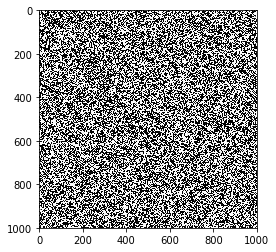

In [7]:
img = cv.imread('wgn.jpg', 0)
plt.imshow(img, cmap = 'gray')
plt.show()

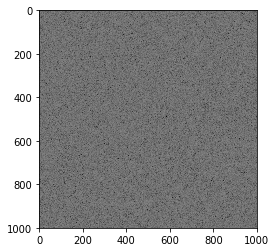

In [8]:
ft = np.log(np.fft.fftshift(np.fft.fft2(img)))
plt.imshow(ft.real, cmap = 'gray')
plt.show()

与我们的讨论相关的是定义噪声空间特性的参数，以及噪声是否与图像相关。频率特性是指傅里叶域中的噪声的频率内容。

### 一些重要的噪声概率密度函数

在第一章的直方图均衡中我们就已经看到，将一张图像视作一个随机变量$X$的结果，当像素的落点是随机的时候，形成噪声图像的异同就取决于$X$的概率分布密度

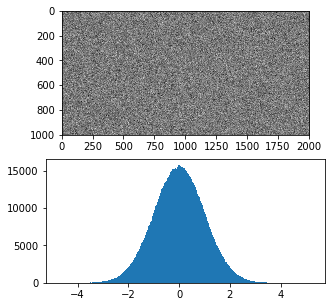

In [21]:
img = np.random.randn(1000, 2000)
plt.figure(figsize = (5, 5))
plt.subplot(211), plt.imshow(img, cmap = 'gray')
plt.subplot(212), plt.hist(img.ravel(), bins = 512)
plt.show()

上面的结果很有意思，这里生成随机数的方法是numpy内置的randn方法，这个随机数生成器是符合正态分布的。下面的这个图是噪声图的灰度频率直方图，可以看到一个非常标准的正态分布曲线

一个指定分布的随机数生成器通常可以使用**逆变换法**或者**舍选法**，具体的实现就不去做了，因为在`numpy.random`模块里面有很全面的随机数生成方案。我们来看一下说明文档

In [19]:
np.info(np.random)

Random Number Generation

==================== =========================================================
Utility functions
random_sample        Uniformly distributed floats over ``[0, 1)``.
random               Alias for `random_sample`.
bytes                Uniformly distributed random bytes.
random_integers      Uniformly distributed integers in a given range.
permutation          Randomly permute a sequence / generate a random sequence.
shuffle              Randomly permute a sequence in place.
seed                 Seed the random number generator.
choice               Random sample from 1-D array.

==================== =========================================================

==================== =========================================================
Compatibility functions
rand                 Uniformly distributed values.
randn                Normally distributed values.
ranf                 Uniformly distributed floating point numbers.
randint              Uniformly distribu

这个模块中提供了很丰富的服从各种类型概率分布的随机数生成器，比如，指数分布：

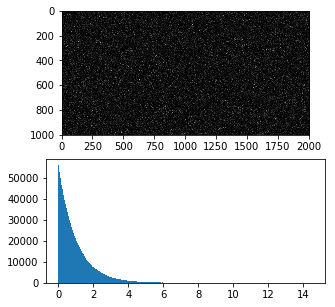

In [23]:
img = np.random.exponential(1, size = (1000, 2000)) # 参数为1的指数分布
plt.figure(figsize = (5, 5))
plt.subplot(211), plt.imshow(img, cmap = 'gray')
plt.subplot(212), plt.hist(img.ravel(), bins = 512)
plt.show()

再比如，通过退化的伯努利分布（两点分布）可以得到椒盐噪声图像

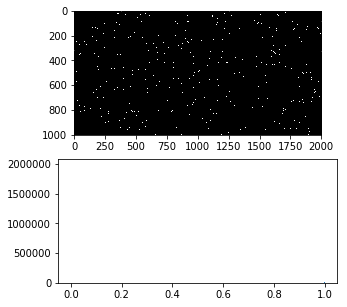

In [33]:
img = np.random.binomial(1, 0.01, size = (1000, 2000)) # 参数为1的指数分布
plt.figure(figsize = (5, 5))
plt.subplot(211), plt.imshow(img, cmap = 'gray')
plt.subplot(212), plt.hist(img.ravel(), bins = 512)
plt.show()

### 典型噪声举例

为了说明加噪之后的图像所具有的特征，下面以一张简单的图像作为加噪的对象

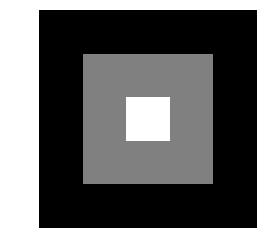

In [45]:
img = np.zeros((1000, 1000))
img[200 : 800, 200 : 800] = 0.3
img[400 : 600, 400 : 600] = 0.6
plt.imshow(img, cmap = 'gray'), plt.axis('off')
plt.show()

1. 高斯噪声
    
    高斯噪声是由下面的概率密度函数定义的：
    
    $$
    f(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x - \mu)^2}{2\sigma^2}}
    $$

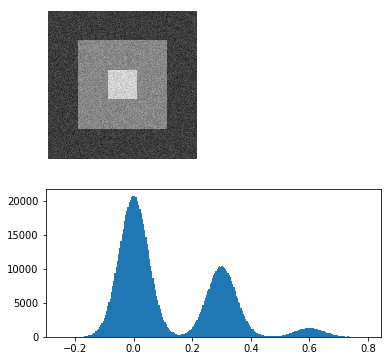

In [64]:
noise = np.random.normal(0, 0.05, size = (1000, 1000))
plt.figure(figsize = (6, 6))
plt.subplot(2, 2, 1), plt.imshow(img + noise, cmap = 'gray'), plt.axis('off')
plt.subplot(2, 1, 2), plt.hist((img + noise).ravel(), bins = 256)
plt.show()

2. 瑞利噪声

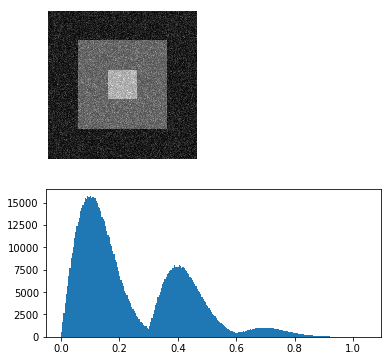

In [68]:
noise = np.random.rayleigh(0.1, size = (1000, 1000))
plt.figure(figsize = (6, 6))
plt.subplot(2, 2, 1), plt.imshow(img + noise, cmap = 'gray'), plt.axis('off')
plt.subplot(2, 1, 2), plt.hist((img + noise).ravel(), bins = 256)
plt.show()

3. 伽马噪声

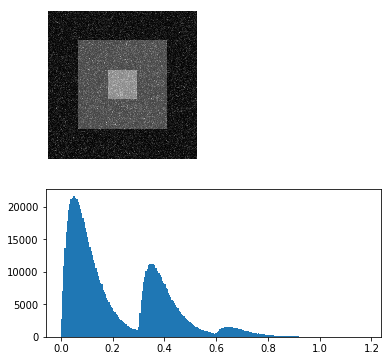

In [74]:
noise = np.random.gamma(2, 0.05, size = (1000, 1000))
plt.figure(figsize = (6, 6))
plt.subplot(2, 2, 1), plt.imshow(img + noise, cmap = 'gray'), plt.axis('off')
plt.subplot(2, 1, 2), plt.hist((img + noise).ravel(), bins = 256)
plt.show()

4. 指数噪声

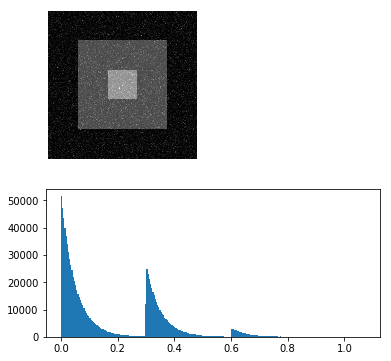

In [75]:
noise = np.random.exponential(0.05, size = (1000, 1000))
plt.figure(figsize = (6, 6))
plt.subplot(2, 2, 1), plt.imshow(img + noise, cmap = 'gray'), plt.axis('off')
plt.subplot(2, 1, 2), plt.hist((img + noise).ravel(), bins = 256)
plt.show()

5. 均匀噪声

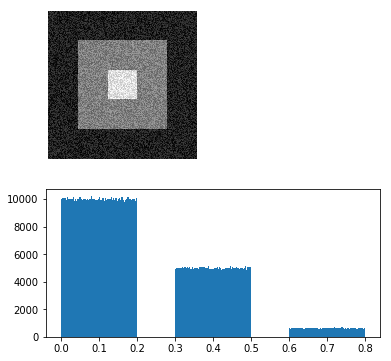

In [82]:
noise = np.random.uniform(0, 0.2, size = (1000, 1000))
plt.figure(figsize = (6, 6))
plt.subplot(2, 2, 1), plt.imshow(img + noise, cmap = 'gray'), plt.axis('off')
plt.subplot(2, 1, 2), plt.hist((img + noise).ravel(), bins = 256)
plt.show()

6. 椒盐噪声

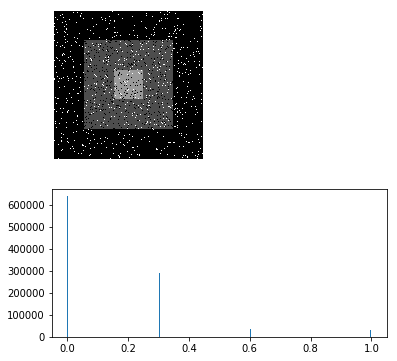

In [101]:
from 椒盐噪声 import salt_noise
noise = salt_noise(img * 256, 100000)
plt.figure(figsize = (6, 6))
plt.subplot(2, 2, 1), plt.imshow(noise, cmap = 'gray'), plt.axis('off')
plt.subplot(2, 1, 2), plt.hist(noise.ravel(), bins = 256)
plt.show()

通过肉眼，是很难辨认出一个特定类型的噪声的，但是通过直方图，我们可以很清晰地看出噪声的类型，从而对它使用相应的去噪手段。

### 周期噪声

图像中的周期噪声是在图像获取期间由电力或者机电干扰产生的。这是本章中讨论的唯一一种空间相关噪声。这种噪声会在图像上留下一个明显的周期纹理，比如**正弦噪声**，被这种噪声污染过的图像在它们的频谱图中会有一对共轭脉冲，表示一个特定频率的波在该图像中占比较大

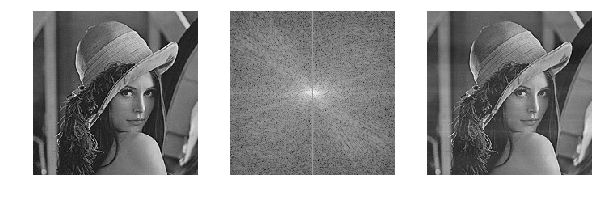

In [2]:
img = cv.imread('lena.jpg', 0)
plt.figure(figsize = (10, 5))
plt.subplot(131), plt.imshow(img, cmap = 'gray'), plt.axis('off')
ft = np.log(np.fft.fftshift(np.fft.fft2(img)))
ft[:, img.shape[1] // 2] = 9 # 加噪
plt.subplot(132), plt.imshow(ft.real, cmap = 'gray'), plt.axis('off')
res = np.fft.ifft2(np.fft.ifftshift(np.exp(ft)))
plt.subplot(133), plt.imshow(res.real, cmap = 'gray'), plt.axis('off')
plt.show()

这种周期噪声的去除则通常采用频率域滤波，因为这种噪声污染具有一个确定的模式，可以在频率域中很明显地看出来

## 只存在噪声的复原——空间滤波

第一节中介绍了图像的退化模型。如果某一个退化过程中只存在噪声的污染，那么可以选择空间滤波的方法。而空间滤波方法在前面已经详细介绍了，这里不再赘述，下面列出并实现几个教材中的典型滤波器

- 均值滤波器
    - 算术均值滤波器
    - 几何均值滤波器
    - 谐波均值滤波器
    - 逆谐波均值滤波器
- 统计排序滤波器
    - 中值滤波器
    - 最大值和最小值滤波器
    - 中点滤波器
    - 修正的阿尔法均值滤波器
- 自适应滤波器
    - 自适应局部降低噪声滤波器
    - 自适应中值滤波器
    
从前章中的空间滤波出发，编写了一个外部脚本`空间滤波器.py`，内部实现了上述几种滤波方法，下面是滤波效果的展示

D:\MyCode\数字图像处理\空间滤波器.py:41: RuntimeWarning: invalid value encountered in power
  res = res ** (1 / (scale ** 2))


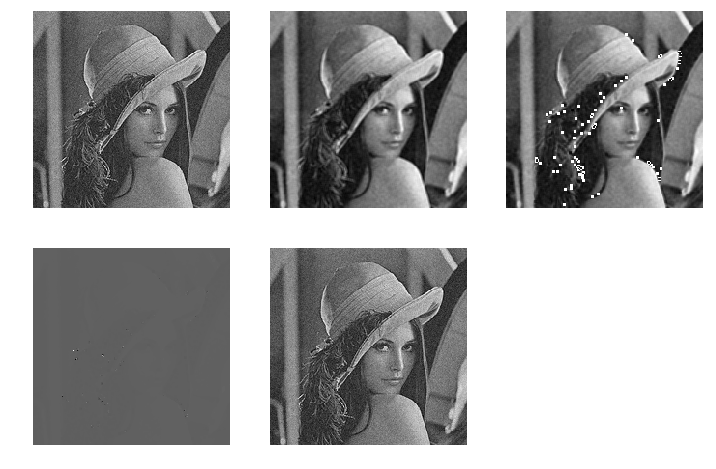

In [6]:
from 空间滤波器 import space_filter
img = cv.imread('lena.jpg', 0) + np.random.normal(0, 10, size = img.shape)
f = space_filter(img)
plt.figure(figsize = (12, 8))
plt.subplot(231), plt.imshow(img, cmap = 'gray'), plt.axis('off') # 加噪的图像
plt.subplot(232), plt.imshow(f.func_filter(3, 'arithmetic'), cmap = 'gray'), plt.axis('off') # 算术均值滤波器
plt.subplot(233), plt.imshow(f.func_filter(3, 'geometric'), cmap = 'gray'), plt.axis('off') # 几何均值滤波器
plt.subplot(234), plt.imshow(f.func_filter(3, 'harmonic'), cmap = 'gray'), plt.axis('off') # 谐波均值滤波器
plt.subplot(235), plt.imshow(f.func_filter(3, 'inv harmonic'), cmap = 'gray'), plt.axis('off') # 逆谐波均值滤波器
plt.show()

上面是均值滤波的结果，可以看到，除了算术平均之外，其他的滤波方法都是渣渣。几何平均的一个最大的问题就是，它对0非常敏感，一旦在计算过程中遇到0则最后的结果也为0，在输出的图像上产生一块一块的斑，谐波均值滤波和逆谐波均值滤波可能有更适用的场合吧，总之在这个例子里面表现很差。